In [1]:
import pickle

with open('loaded_data.dat','rb') as f:
    notes_train = pickle.load(f)
    labels_train = pickle.load(f)
    up_notes_train = pickle.load(f)
    up_labels_train = pickle.load(f)
    gold_labels_train = pickle.load(f)
    notes_test = pickle.load(f)
    labels_test = pickle.load(f)
    gold_labels_test = pickle.load(f)

labels = labels_train + labels_test

flattened_labels = [j for doc_label in [i for label in labels for i in label] for j in doc_label]

labels_set = {i:flattened_labels.count(i) for i in set(flattened_labels)}

x = [k for k in sorted(labels_set, key=labels_set.get, reverse=True)]
y = [labels_set[k] for k in sorted(labels_set, key=labels_set.get, reverse=True)]

In [8]:
import os
import numpy as np
import time

from gensim.models import Word2Vec
from keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, hamming_loss, f1_score, roc_auc_score
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical

from models import get_rnn_model
from cm import multilabel_confusion_matrix, plot_confusion_matrix
from data_process import get_embedding_matrix, data_generator, get_all_notes_labels, get_features, get_targets, get_gold_label_targets

# Customized Evaluation for keras model
class CustomEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = list(validation_data)

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = []
            for x in self.X_val:
                y = np.squeeze(self.model.predict_on_batch(x))
                y_pred.append(y)
            y_pred = np.concatenate(y_pred)
            y_pred_ham = y_pred > 0.5
            y_val = np.concatenate(self.y_val)
            roc = roc_auc_score(y_val, y_pred, average='micro')
            loss = log_loss(y_val, y_pred)
            ham = hamming_loss(y_val, y_pred_ham)
            sub = accuracy_score(y_val, y_pred_ham)
            f1 = f1_score(y_val, y_pred_ham, average='micro')
            print("Adiitional val metrics: - ROC-AUC: %.6f - Log-Loss: %.6f - Hamming-Loss: %.6f - Subset-Accuracy: %.6f - F1-Score: %.6f" % (roc, loss, ham, sub, f1))

In [ ]:
param = {'up': 5, 'window_size': 3, 'embed_size': 5, 'latent_dim': 5, 'dropout_rate': 0.0, 'epochs': 1, 'category': None}

print('*'*80)
print("Parameters (note: embed_size*10, latent_dim*64):\n", param)
print('*'*80)

# assign parameters
up = int(param['up'])
window_size = int(param['window_size'])
embed_size = int(param['embed_size'] * 10)
latent_dim = int(param['latent_dim'] * 64)
dropout_rate = param['dropout_rate']
epochs = param['epochs']
category = param['category']
max_features = 60000 #param['max_features']
train_embed = True #param['train_embed']
model_type = 'CuDNNLSTM' #param['model_type']

# upsampling
if up > 0:
    print('upsampling for %d times...' % (up))
    notes_train = [note + up * up_note for note, up_note in zip(notes_train, up_notes_train)]
    labels_train = [label + up * up_label for label, up_label in zip(labels_train, up_labels_train)]
notes = notes_train + notes_test
labels = labels_train + labels_test
gold_labels = gold_labels_train + gold_labels_test

# prepare features
X_train_seq, X_test_seq, word_index = get_features(max_features, notes_train, notes_test, verbose=1)
nb_words = min(max_features, len(word_index))

# prepare embedding matrix
if train_embed:
    print('preparing pretrained embedding matrix ...')
    w2v = Word2Vec(notes, size=embed_size, window=window_size, min_count=1, workers=4)
    embedding_index = dict(zip(w2v.wv.index2word, w2v.wv.vectors))
    embedding_matrix = get_embedding_matrix(embedding_index=embedding_index, 
                                            word_index=word_index, 
                                            max_features=max_features, 
                                            embed_size=embed_size)

# prepare targets
Y_train, Y_test, mlb, num_labels = get_targets(labels_train, labels_test, category, verbose=1)  

# get rnn model
model = get_rnn_model(nb_words=nb_words, 
                      num_labels=num_labels, 
                      embed_size=embed_size, 
                      latent_dim=latent_dim, 
                      model_type=model_type, 
                      embedding_matrix=embedding_matrix, 
                      dropout=dropout_rate, 
                      train_embed=train_embed)
 
print('model summary:')
print(model.summary())

# model compiling
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model training
print('\ntraining model ...')
custevl = CustomEvaluation(validation_data=(X_test_seq, Y_test), interval=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=2, verbose=0, mode='auto')
train_gen = data_generator(X_train_seq, Y_train)
test_gen = data_generator(X_test_seq, Y_test)
hist = model.fit_generator(train_gen,
                            steps_per_epoch=len(Y_train),
                            epochs=epochs,
                            validation_data=test_gen,
                            validation_steps=len(Y_test),
                            callbacks=[custevl, earlystop],
                            verbose=1)

# prediction of test data
print('predicting test data ...')
Y_pred = []
for x in X_test_seq:
    x = np.array(x).reshape((1,-1))
    y_pred = np.squeeze(model.predict_on_batch(x))
    Y_pred.append(y_pred)
Y_pred_concat = np.concatenate(Y_pred)
Y_val = np.concatenate(Y_test)

# confusion matrix  
# cm = multilabel_confusion_matrix(Y_val, np.where(Y_pred_concat > 0.5, 1, 0))
# for i, j in zip(cm, mlb.classes_):
#     print(j+':\n', i,'\n')

# prepare gold label targets
Y_gold_test, Y_gold_pred, gmlb = get_gold_label_targets(Y_pred, gold_labels, gold_labels_test, mlb, category=category, verbose=1) 


F1 Scores for global labels:
ALL (average="micro"): 0.618925189690851

F1 Scores for individual global labels:


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


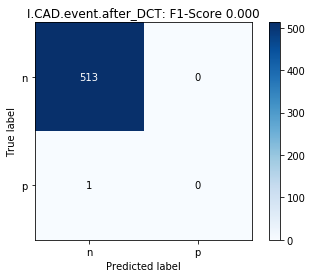

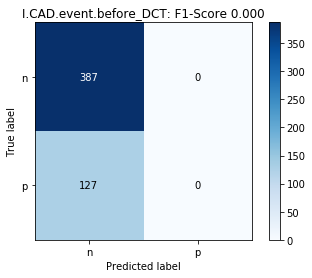

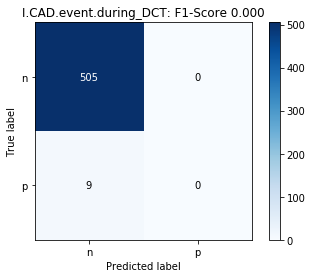

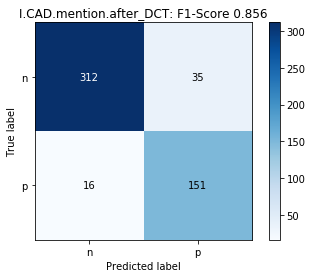

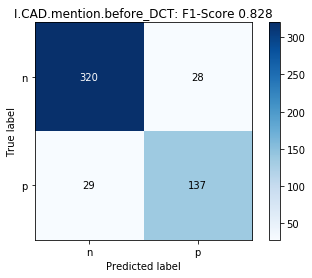

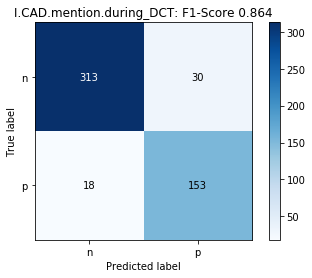

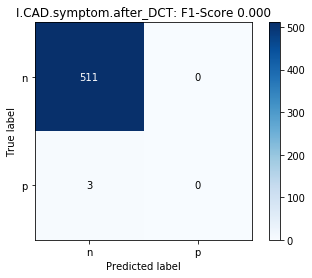

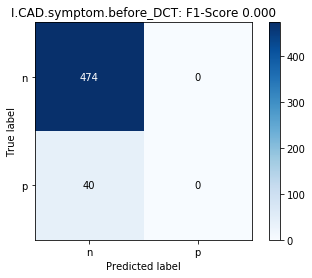

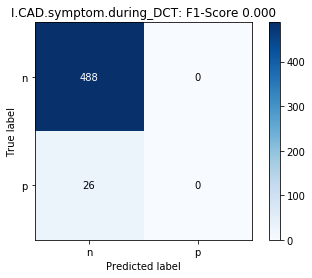

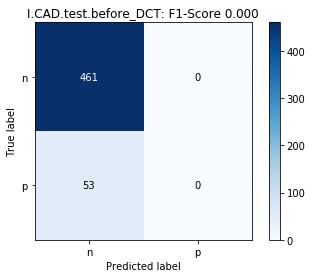

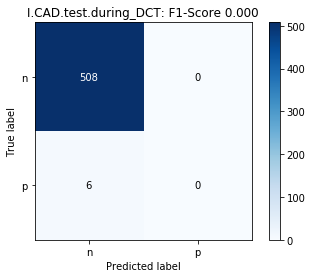

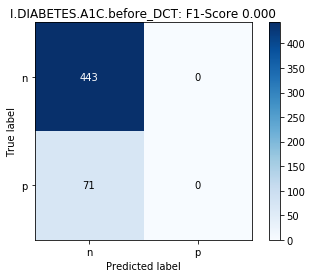

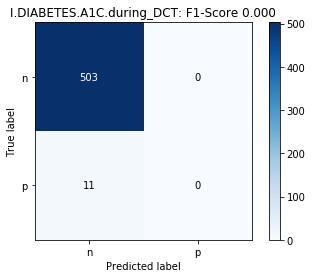

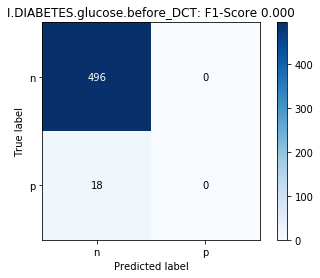

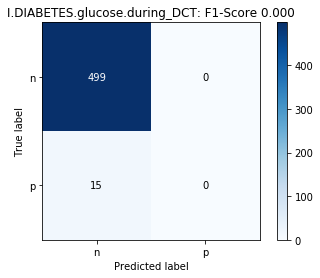

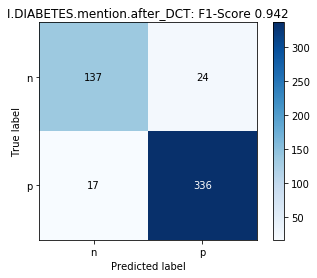

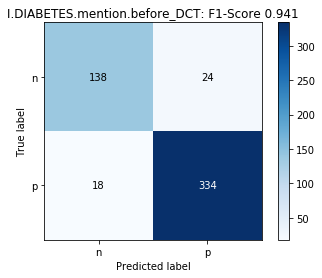

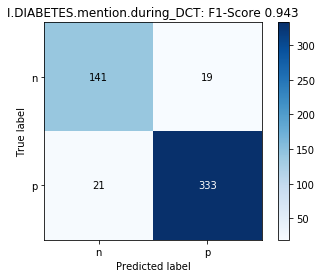

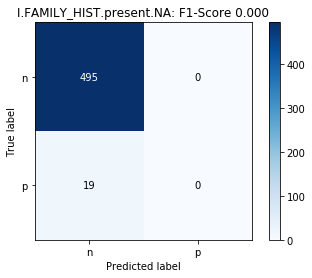

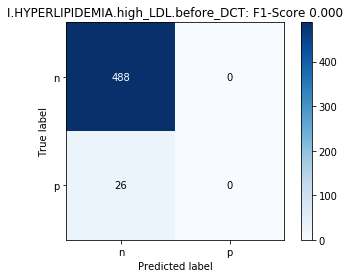

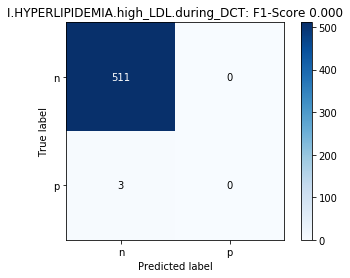

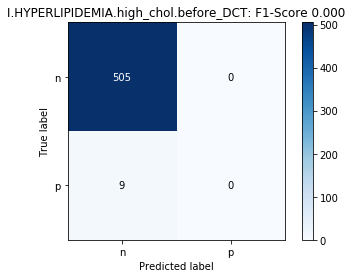

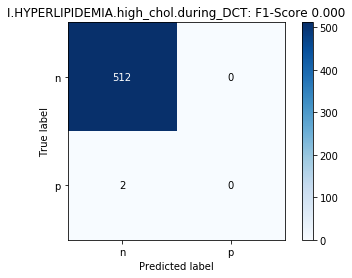

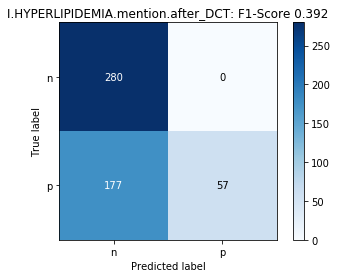

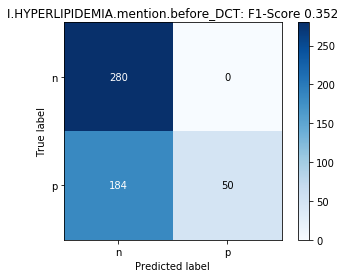

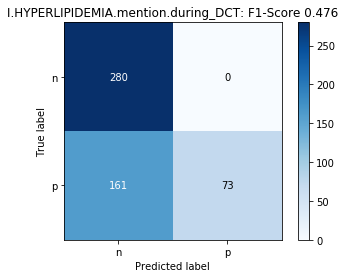

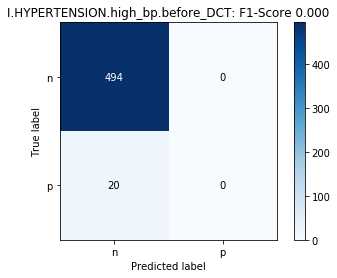

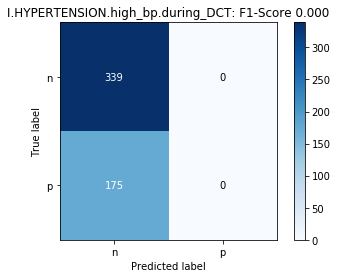

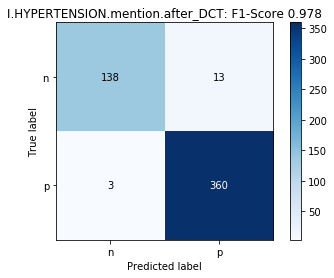

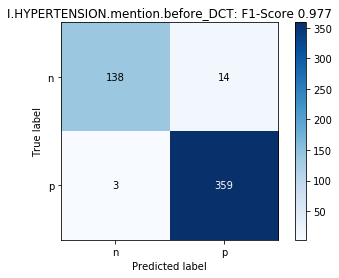

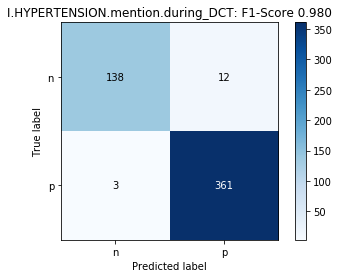

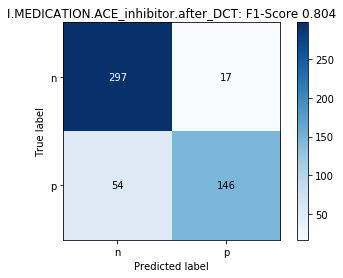

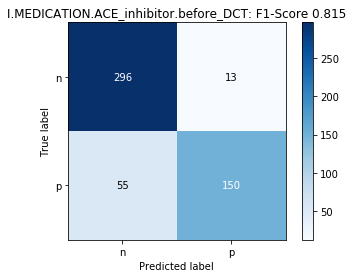

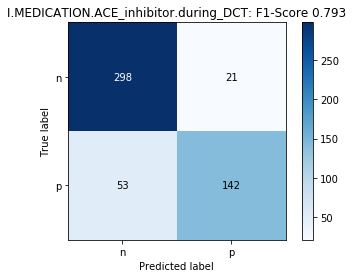

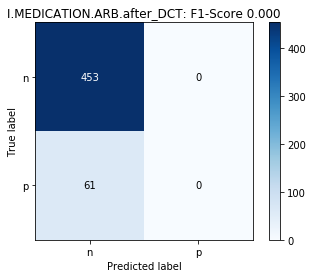

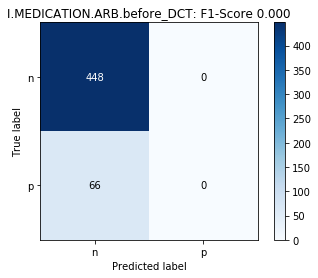

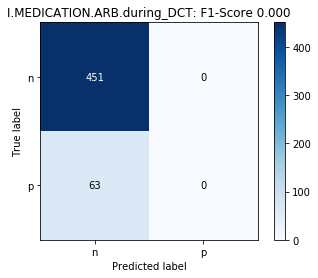

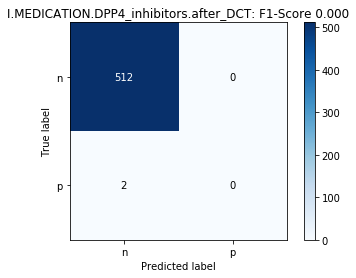

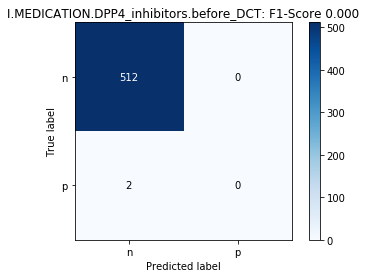

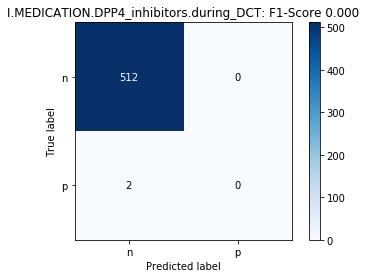

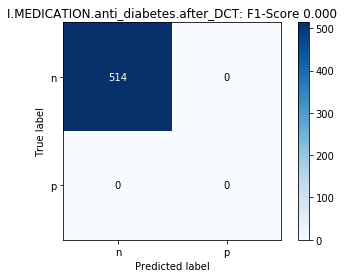

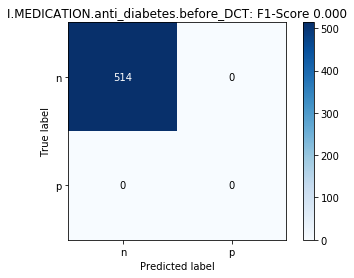

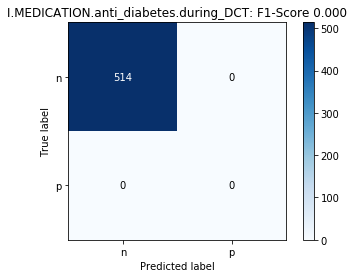

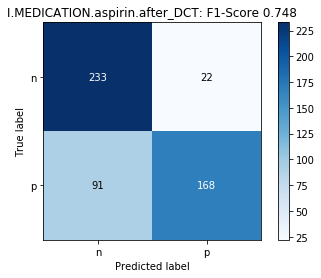

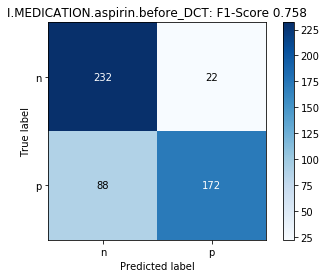

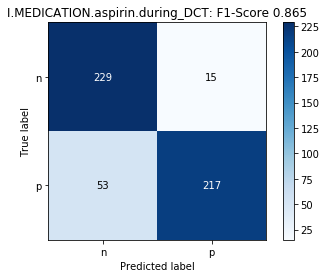

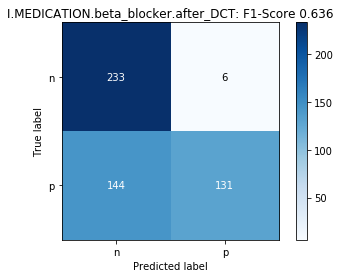

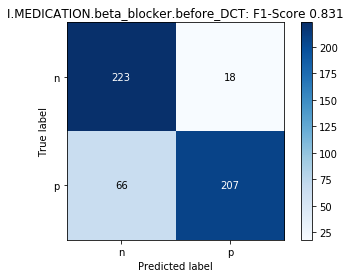

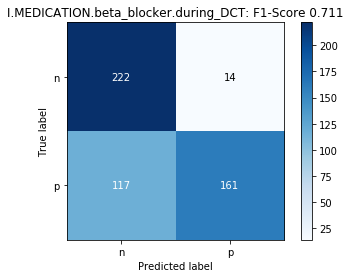

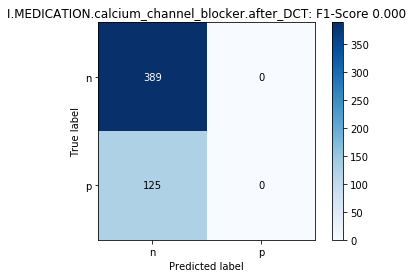

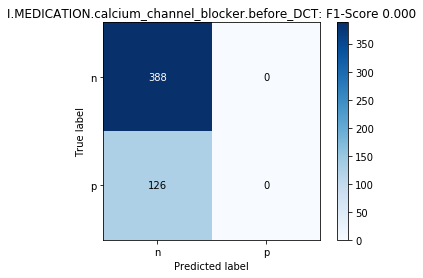

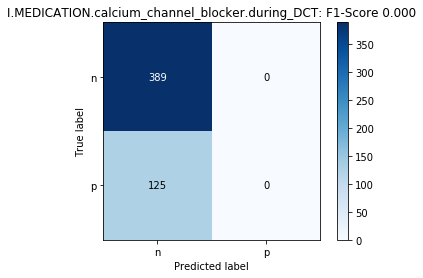

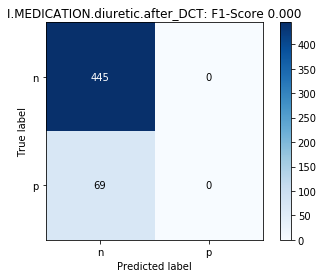

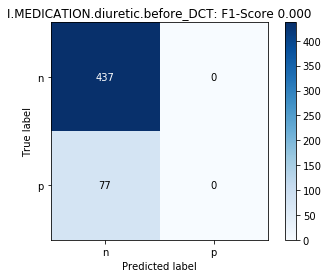

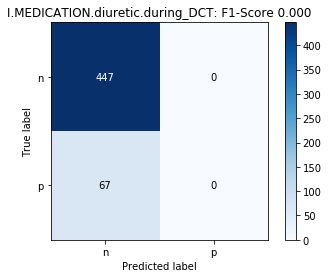

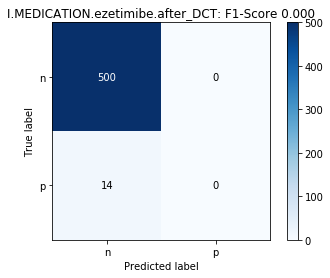

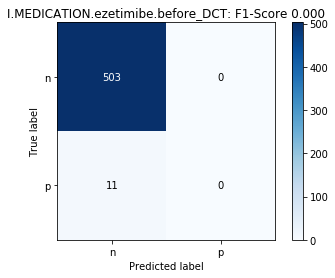

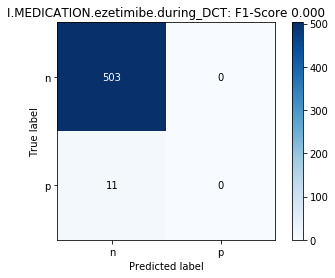

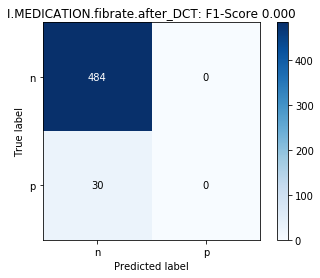

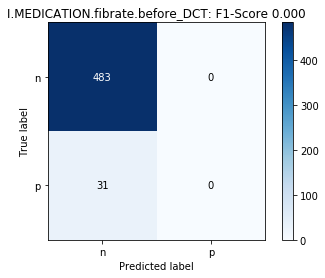

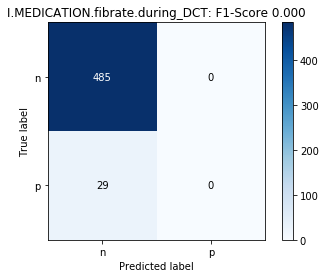

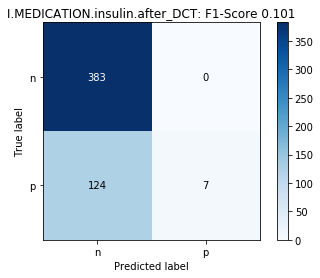

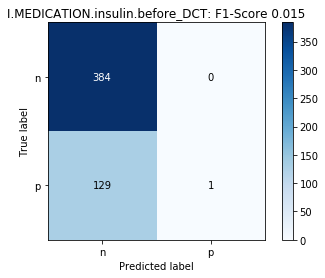

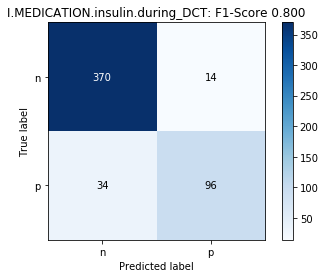

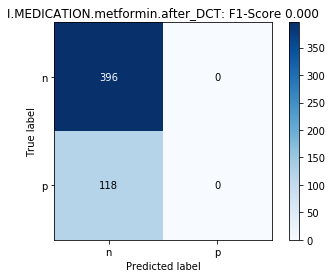

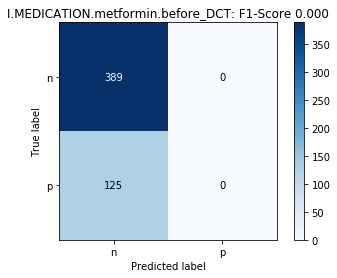

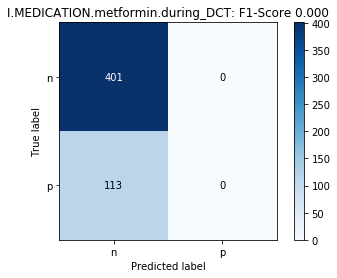

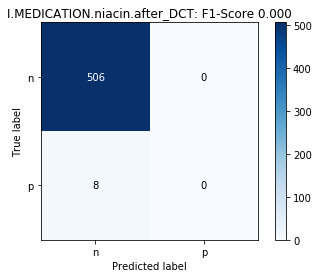

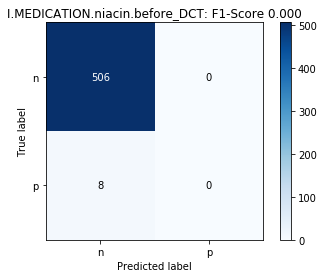

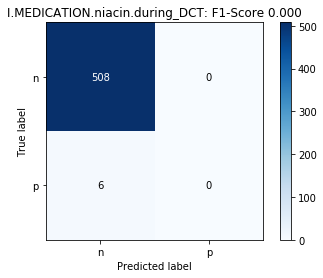

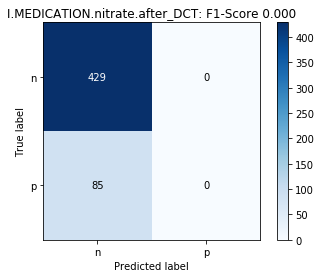

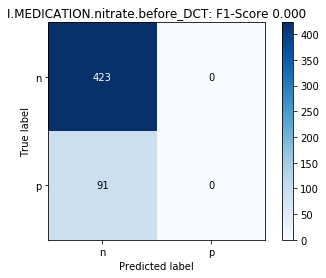

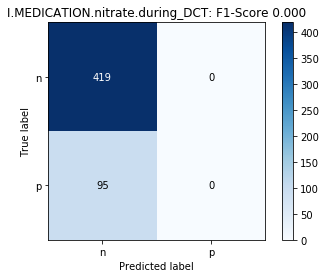

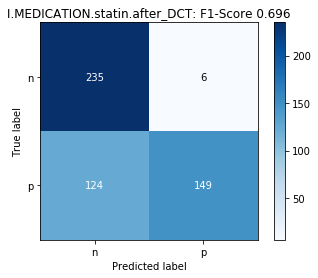

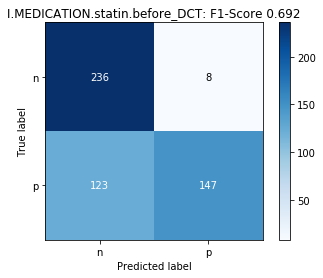

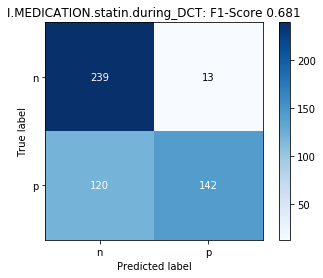

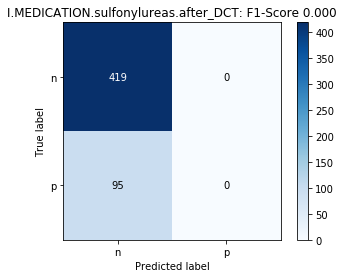

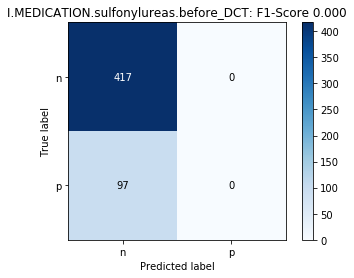

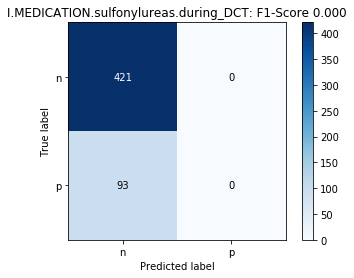

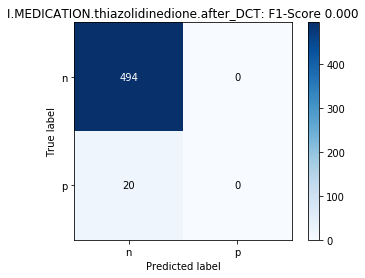

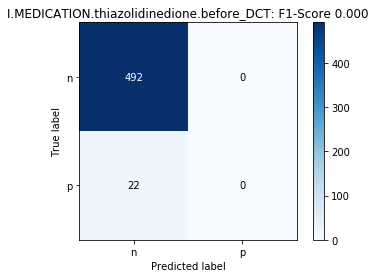

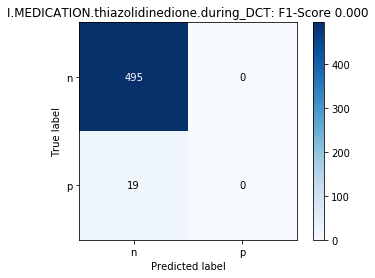

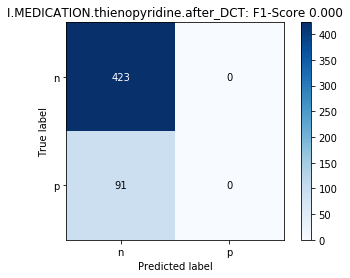

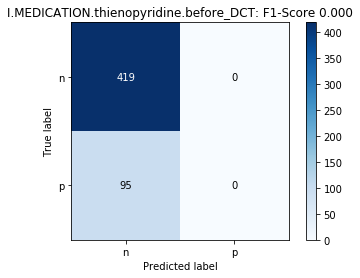

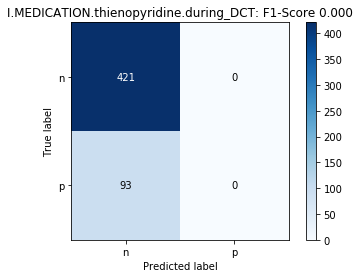

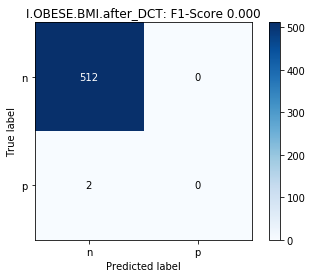

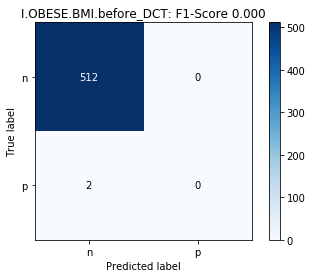

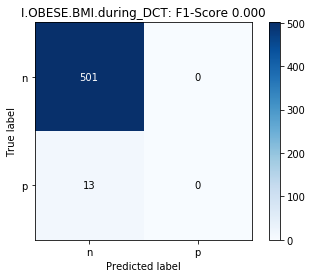

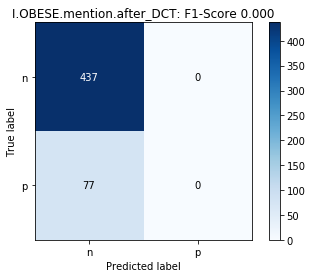

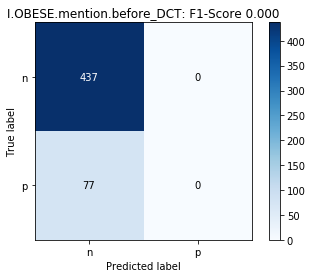

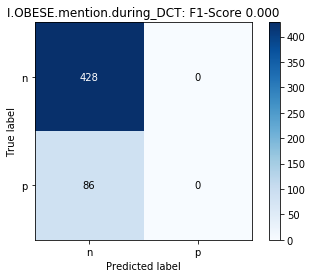

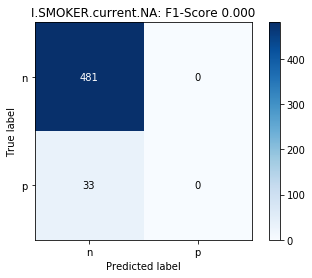

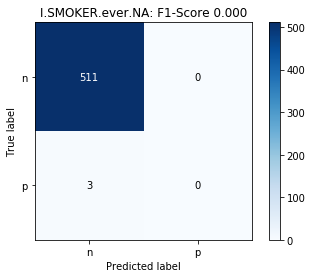

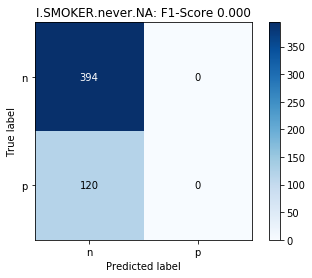

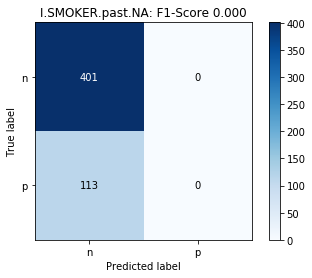

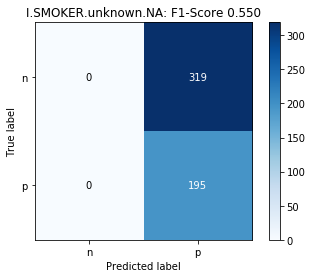

In [25]:
# f1 scores for gold label
f1 = f1_score(Y_gold_test, Y_gold_pred, average='micro')
print('\nF1 Scores for global labels:\nALL (average="micro"):', f1)

# confusion matrix for gold label
gcm = multilabel_confusion_matrix(Y_gold_test, Y_gold_pred)

# f1 score for individual gold label
f1_all = f1_score(Y_gold_test, Y_gold_pred, average=None)

print("\nF1 Scores for individual global labels:")
for i, j, k in zip(f1_all, gcm, gmlb.classes_):
    t = '%s: F1-Score %5.3f'% (k, i)
#     print(t)
    plot_confusion_matrix(j, title=t)    